# Outfit diagnosis with multi-layered comparison network

This notebook show example to diagnose the outfit by computing the backpropageted gradients on the **comparison matrices** of different layers.

In [1]:
import itertools
import os
import warnings

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from sklearn import metrics

import resnet
from utils import prepare_dataloaders

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc('font',family='Times New Roman')
%load_ext autoreload
%autoreload 2

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Dataloader
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = (
    prepare_dataloaders()
)

iterator = iter(test_loader)
batch = next(iterator)
lengths, images, names, offsets, set_ids, labels, is_compat = batch

In [3]:
from model import CompatModel

device = torch.device("cuda:0")
model = CompatModel(embed_size=1000, need_rep=True, vocabulary=len(train_dataset.vocabulary)).to(device)

# Load model weights
model.load_state_dict(torch.load('./model_train_relation_vse_type_cond_scales.pth'))
model.eval()

CompatModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2

# Compute Gradients on Comparison Matrices

First define several helper function.

In [4]:
def loadimg_from_id(ID, root_dir=test_dataset.root_dir):
    """load image from pre-defined id.
    
    Args:
        ID: List of ids of 5 items.
        
    Return:
        imgs: torch.tensor of shape (1, 5, 3, 224, 224)
    """
    imgs = []
    for id in ID:
        if 'mean' in id:
            img_path = os.path.join(test_dataset.data_dir, id.split('_')[0]) + '.png'
        else:
            img_path = os.path.join(root_dir, *id.split('_')) + '.jpg'
        img = Image.open(img_path).convert('RGB')
        img = test_dataset.transform(img)
        imgs.append(img)
    imgs = torch.stack(imgs)
    imgs = imgs.unsqueeze(0)
    return imgs

In [5]:
def defect_detect(img, model, normalize=True):
    """ Compute the gradients of each element in the comparison matrices to 
    approximate the problem of each input.
    
    Args:
        img: images of shape (N, 3, 224, 224).
        model: the model to compute the compatibility score.
        normalize: whether to normalize the relation results.
        
    Return:
        relation: gradients on comparison matrix.
        out: prediction score.
    """
    # Register hook for comparison matrix
    relation = None
    def func_r(module, grad_in, grad_out):
        nonlocal relation
        relation = grad_in[1].detach()

    for name, module in model.named_modules():
        if name == 'fc1':
            module.register_backward_hook(func_r)

    # Forward
    out, *_ = model._compute_score(img)
    one_hot = torch.FloatTensor([[-1]]).to(device)

    # Backward
    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)
    
    if normalize:
        relation = relation / (relation.max() - relation.min())
    relation += 1e-3
    return relation, out.item()

In [6]:
def vec2mat(relation, select):
    """ Convert relation vector to 4 matrix, which is corresponding to 4 layers
    in the backend CNN.
    
    Args:
        relation: (np.array | torch.tensor) of shpae (60,)
        select: List of select item indices, e.g. (0, 2, 3) means select 3 items
            in total 5 items in the outfit.
        
    Return:
        mats: List of matrix
    """
    mats = []
    for idx in range(4):
        mat = torch.zeros(5, 5)
        mat[np.triu_indices(5)] = relation[15*idx:15*(idx+1)]
        mat += torch.triu(mat, 1).transpose(0, 1)
        mat = mat[select, :]
        mat = mat[:, select]
        mats.append(mat)
    return mats

In [7]:
def show_rela_diagnosis(relation, select, cmap=plt.cm.Blues):
    """ Visualize diagnosis on relationships of 4 scales
    
    Args:
        relation: (np.array | torch.tensor) of shpae (60,)
        select: List of select item indices
    """
    mats = vec2mat(relation , select)
        
    fig = plt.figure(figsize=(20, 5))
    all_names = {0:'Top', 1:'Bottom', 2:'Shoe', 3:'Bag', 4:'Accssory'}
    node_names = {i:all_names[s] for i, s in enumerate(select)}
    
    edge_vmax = max(m.max() for m in mats)
    edge_vmin = min(m.min() for m in mats)
    
    container = []
    for idx in range(4):
        A = mats[idx]
        if isinstance(A, torch.Tensor):
            A = A.cpu().data.numpy()
                   
        A = np.triu(A, k=1)
        A = np.round(A, decimals=2)
        container.append(A)
    container = np.stack(container)
    sorted_vedge = sorted(container.ravel(), reverse=True)
        
    for idx in range(4):
        plt.subplot(1, 4, idx+1)
        plt.title("Layer {}".format(idx+1), fontsize=28)
        A = mats[idx]
        if isinstance(A, torch.Tensor):
            A = A.cpu().data.numpy()
                   
        A = np.triu(A, k=1)
        A = np.round(A, decimals=2)
        indices = np.triu_indices(A.shape[0], k=1)
        weights = A[indices[0], indices[1]]
        # Generate graph
        G = nx.Graph()
        for i, j, weight in zip(*indices, weights):
            G.add_edge(node_names[i], node_names[j], weight=weight)
        
        elarge, esmall, filtered_weights = [], [], []
        for e in G.edges(data=True):
            if e[2]['weight'] in sorted_vedge[:3]:
                elarge.append((e[0], e[1]))
            else:
                esmall.append((e[0], e[1]))
                filtered_weights.append(e[2]['weight'])
        pos=nx.circular_layout(G) # positions for all nodes

        # nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes()], node_size=1600, node_color='#A0CBE2')

        # edges
        nx.draw_networkx_edges(G,pos,edgelist=esmall, width=6, alpha=0.5, edge_color=filtered_weights, edge_cmap=cmap,
                               edge_vmax=edge_vmax, edge_vmin=edge_vmin)
        nx.draw_networkx_edges(G,pos,edgelist=elarge, width=6, alpha=0.5, edge_color='red', style='dashed')

        # labels
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_labels(G,pos, font_size=18, font_family='Times New Roman')
        if len(select) == 4:
            nx.draw_networkx_edge_labels(G, pos, font_size=18, font_family='Times New Roman', edge_labels=labels, label_pos=0.33)
        else:
            nx.draw_networkx_edge_labels(G, pos, font_size=18, font_family='Times New Roman', edge_labels=labels)
        
        plt.axis('off')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [8]:
def item_diagnosis(relation, select):
    """ Output the most incompatible item in the outfit
    
    Return:
        result (list): Diagnosis value of each item 
        order (list): The indices of items ordered by its importance
    """
    mats = vec2mat(relation, select)
    for m in mats:
        mask = torch.eye(*m.shape).byte()
        m.masked_fill_(mask, 0)
    result = torch.cat(mats).sum(dim=0)
    order = [i for i, j in sorted(enumerate(result), key=lambda x:x[1], reverse=True)]
    return result, order

In [9]:
def show_imgs(x, select=None):
    """ Show multiple items in a outfit.
    
    Args:
        x: torch.tensor of shape(5, 3, 224, 224)
        select: List of selected item index
    """
    if select is None:
        select = list(range(5))
    fig = plt.figure(figsize=(5*len(select), 5))
    for i, s in enumerate(select):
        plt.subplot(1, len(select), i+1)
        img = x[s]
        img = img.cpu().data.numpy().transpose((1, 2, 0)) * 255
        img = img[..., :3]
        plt.gca().axis('off')
        plt.imshow(np.uint8(img))
    plt.show()

In [10]:
def retrieve_sub(x, select, order):
    """ Retrieve the datset to substitute the worst item for the best choice.
    """
    all_names = {0:'upper', 1:'bottom', 2:'shoe', 3:'bag', 4:'accessory'}
   
    best_score = -1
    best_img_path = dict()

    for o in order:
        if best_score > 0.9:
            break
        problem_part_idx = select[o]
        problem_part = all_names[problem_part_idx]
        for outfit in test_dataset.data:
            if best_score > 0.9:
                break
            if problem_part in outfit[1]:
                img_path = os.path.join(test_dataset.root_dir, outfit[0], str(outfit[1][problem_part]['index'])) + '.jpg'
                img = Image.open(img_path).convert('RGB')
                img = test_dataset.transform(img).to(device)
                x[0][problem_part_idx] = img
                with torch.no_grad():
                    score, *_ = model._compute_score(x)
                if score.item() > best_score:
                    best_score = score.item()
                    best_img_path[problem_part] = img_path
        x[0][problem_part_idx] = test_dataset.transform(Image.open(best_img_path[problem_part]).convert('RGB')).to(device)
    
        print('problem_part: {}'.format(problem_part))
        print('best substitution: {}'.format(best_img_path[problem_part]))
        print('After substitution the score is {:.4f}'.format(best_score))
        plt.imshow(plt.imread(best_img_path[problem_part]))
        plt.gca().axis('off')
        plt.show()
    
    show_imgs(x[0], select)
    return best_score, best_img_path

# Main program

1. Show prediction, diagnosis and revision results by specifiy ID.

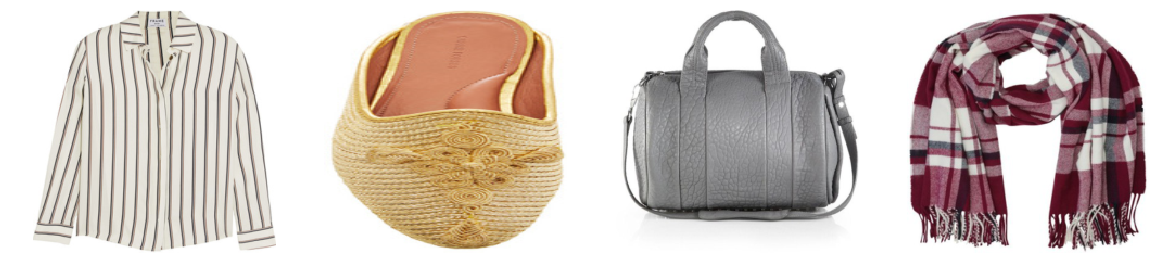

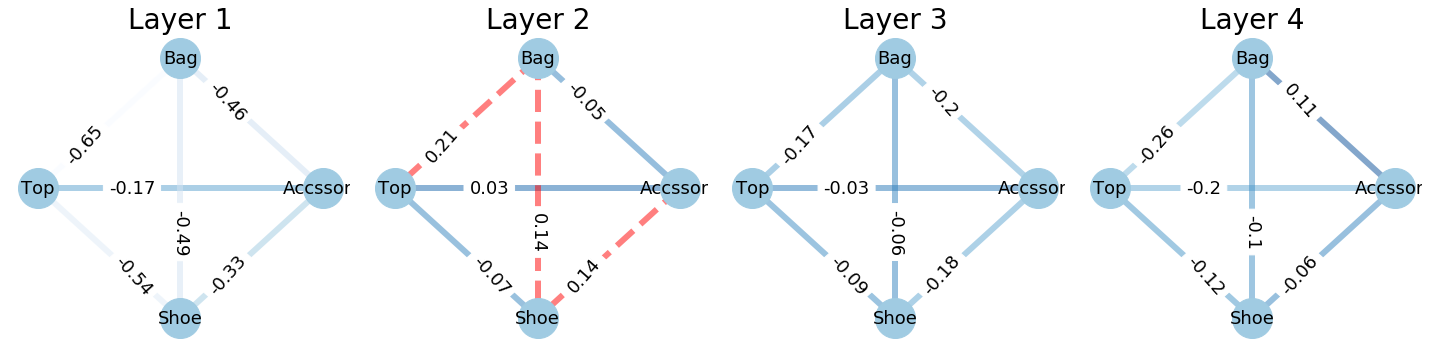

Predicted Score: 0.0000
Problem value of each item: tensor([-2.0556, -1.7692, -1.9857, -1.3940])
Order: [3, 1, 2, 0]

problem_part: accessory
best substitution: ../data/images/195504873/6.jpg
After substitution the score is 0.0021


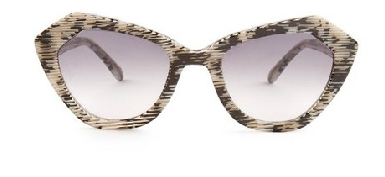

problem_part: shoe
best substitution: ../data/images/210631995/2.jpg
After substitution the score is 0.9607


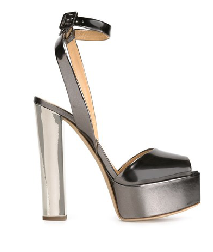

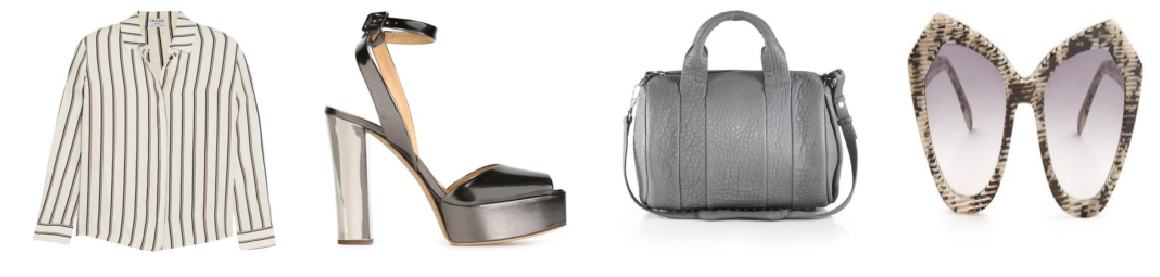

In [11]:
print("="*88)
# You can specify ID here.
ID = ['178118160_1', 'bottom_mean', '199285568_4', '111355382_5', '209432387_4']
x = loadimg_from_id(ID).to(device)
# kick out the mean images for padding the sequence when making visualization
select = [i for i, l in enumerate(ID) if 'mean' not in l]

# Step 1: show images in an outfit
show_imgs(x[0], select)

# Step 2: show diagnosis results
relation, out = defect_detect(x, model)
relation = relation.squeeze().cpu().data
show_rela_diagnosis(relation, select, cmap=plt.cm.Blues)
result, order = item_diagnosis(relation, select)
print("Predicted Score: {:.4f}\nProblem value of each item: {}\nOrder: {}\n".format(out, result, order))

# Step 3: substitute the problem items for revision
best_score, best_img_path = retrieve_sub(x, select, order)
print("="*88)

2. Show prediciton, diagnosis of a batch of test samples.

ID: ['204421067_1', 'bottom_mean', '202412456_3', '214716404_4', '187592500_5']


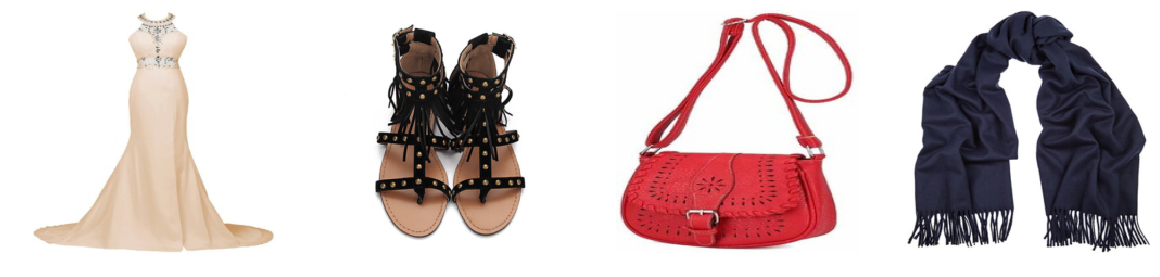

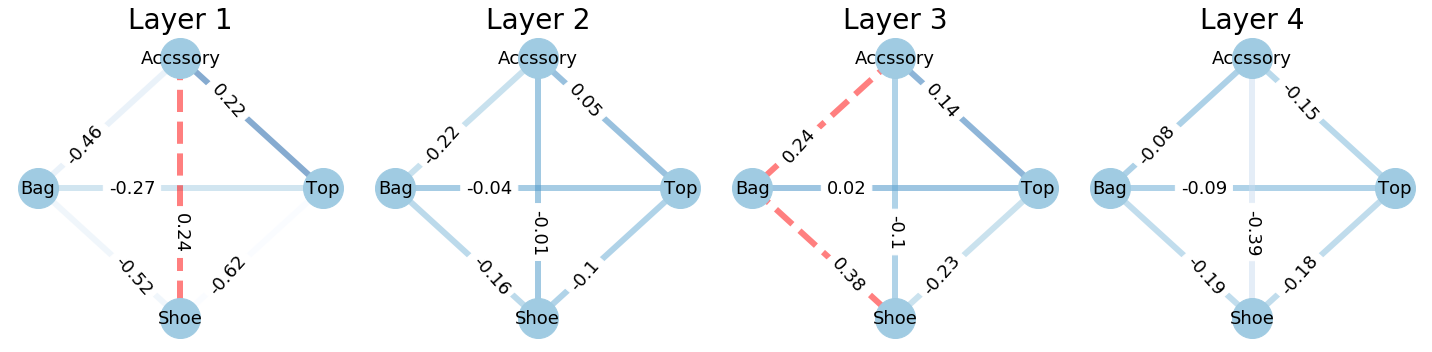

Predicted Score: 0.0865
Problem value of each item: tensor([-1.2730, -1.8990, -1.3945, -0.5205])
Order: [3, 0, 2, 1]

ID: ['140106066_1', '139731278_2', '215327132_4', 'bag_mean', '211697041_4']


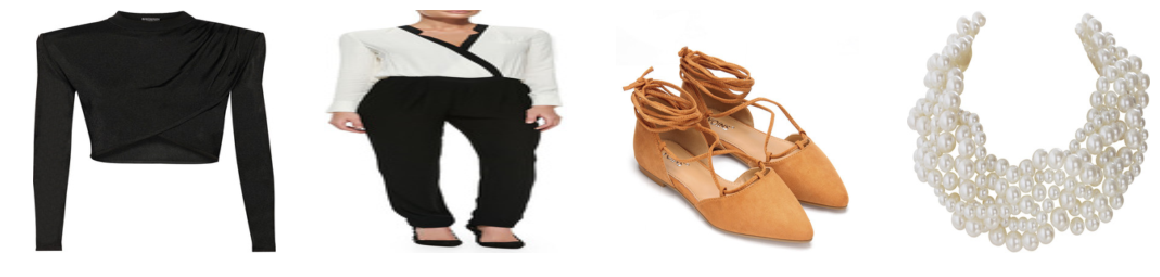

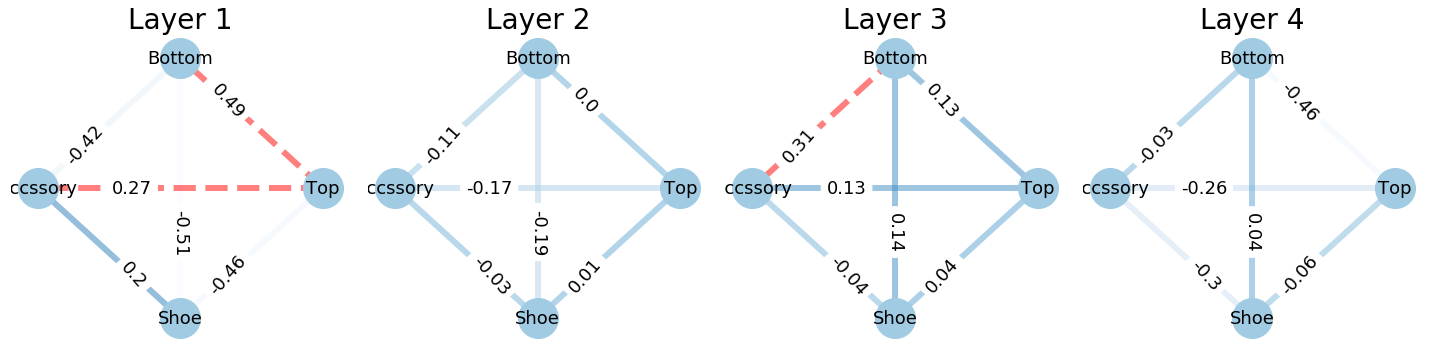

Predicted Score: 0.0000
Problem value of each item: tensor([-0.3391, -0.5977, -1.1726, -0.4521])
Order: [0, 3, 1, 2]

ID: ['108112189_1', '216678271_2', '200786021_3', 'bag_mean', 'accessory_mean']


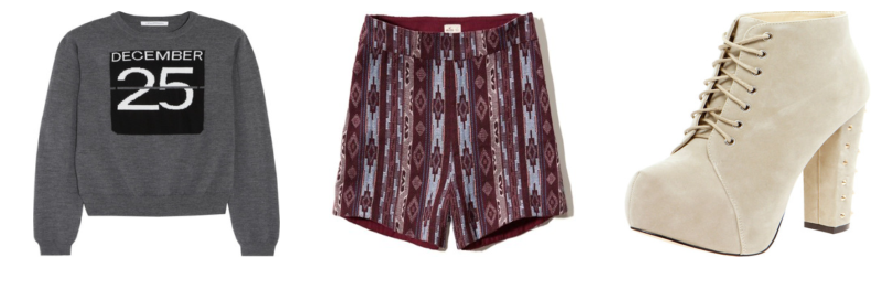

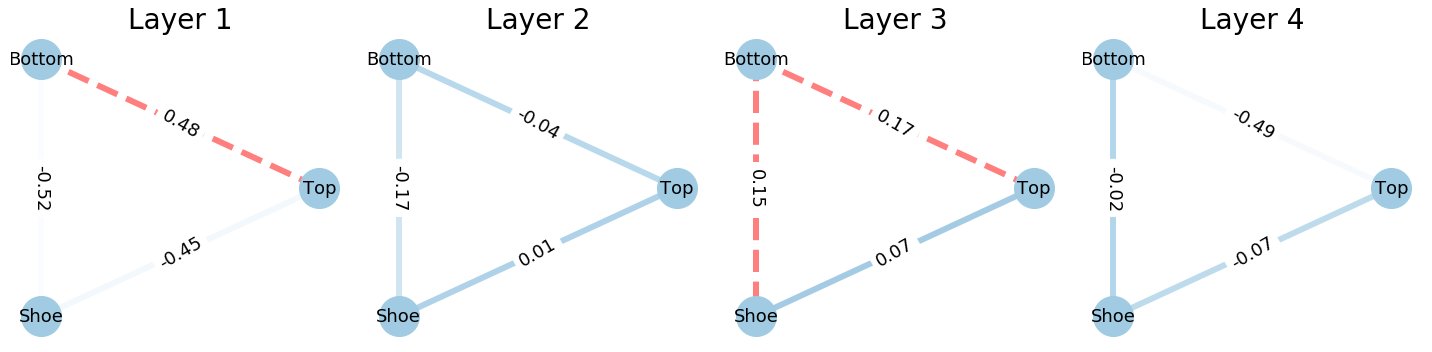

Predicted Score: 0.0011
Problem value of each item: tensor([-0.3288, -0.4462, -0.9996])
Order: [0, 1, 2]

ID: ['127389151_1', 'bottom_mean', 'shoe_mean', '190117110_4', '171755122_4']


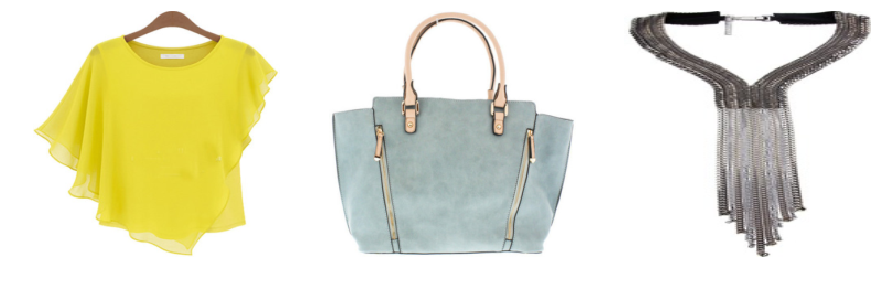

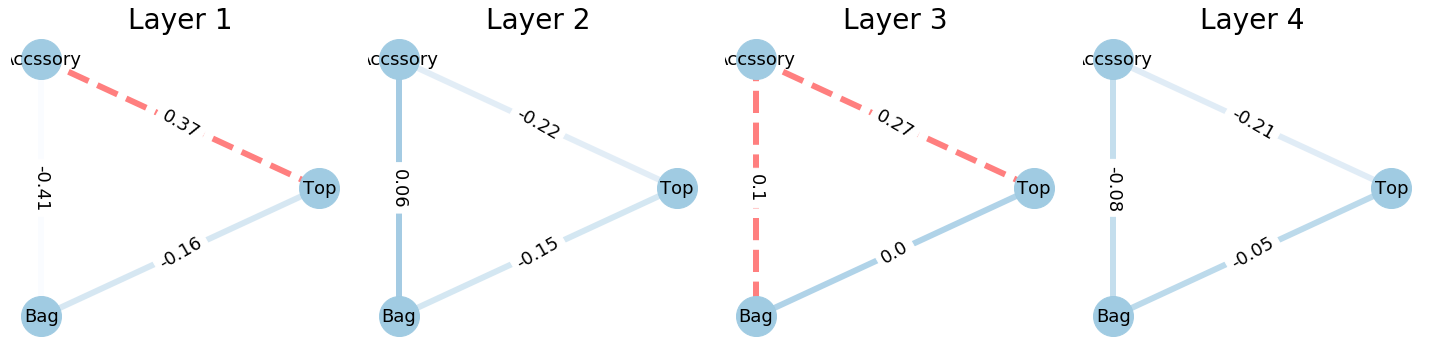

Predicted Score: 0.0463
Problem value of each item: tensor([-0.1466, -0.6761, -0.1135])
Order: [2, 0, 1]

ID: ['187950801_1', '198450014_1', '129931699_5', '136842112_3', 'accessory_mean']


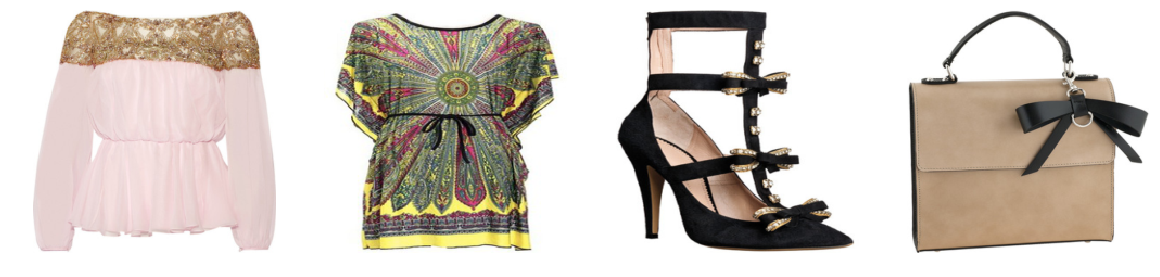

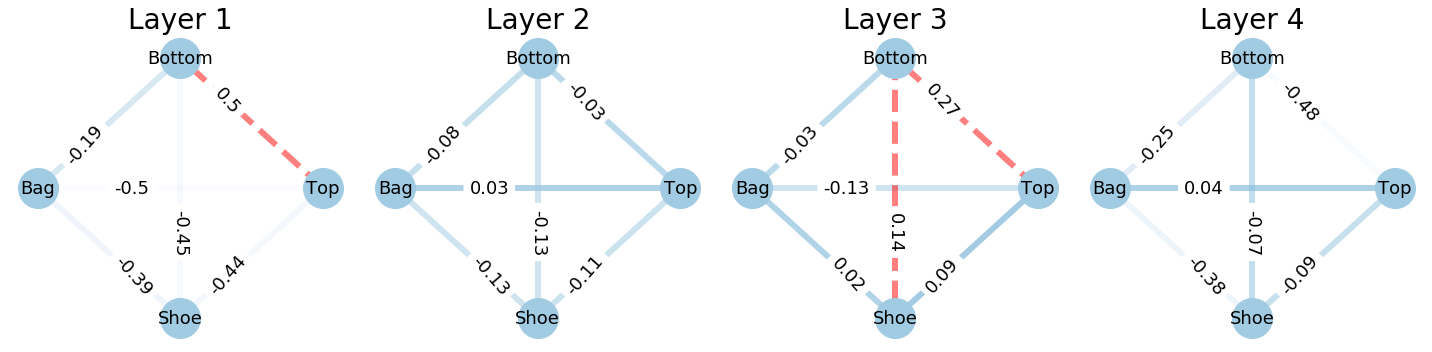

Predicted Score: 0.0405
Problem value of each item: tensor([-0.8446, -0.7899, -1.9250, -1.9987])
Order: [1, 0, 2, 3]

ID: ['148065168_1', '124186534_1', '216775823_2', '213601567_5', 'accessory_mean']


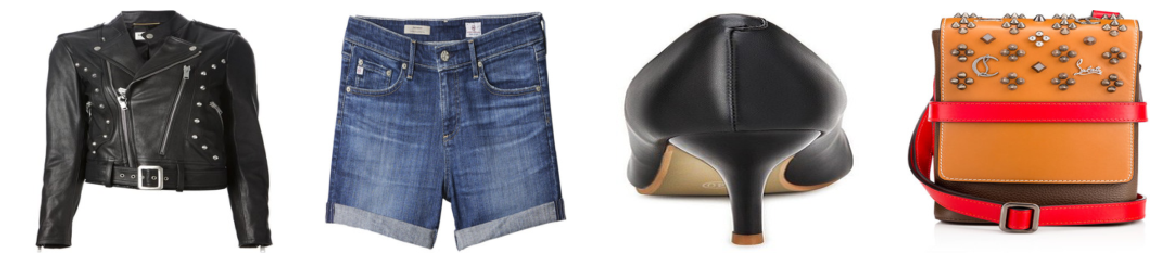

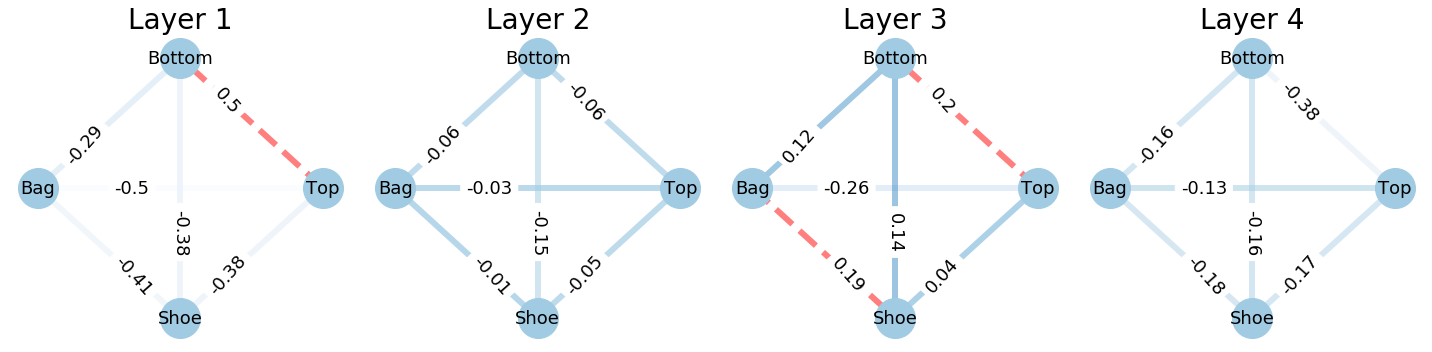

Predicted Score: 0.0003
Problem value of each item: tensor([-1.2412, -0.6919, -1.5244, -1.7345])
Order: [1, 0, 2, 3]

ID: ['171980021_1', 'bottom_mean', '190781991_3', '180694979_5', '118279355_4']


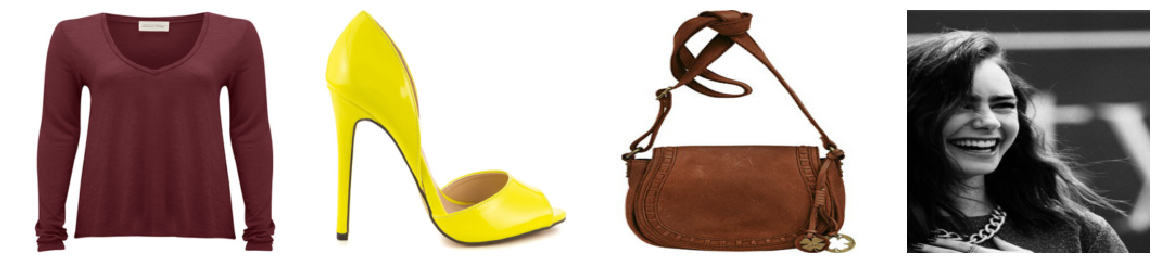

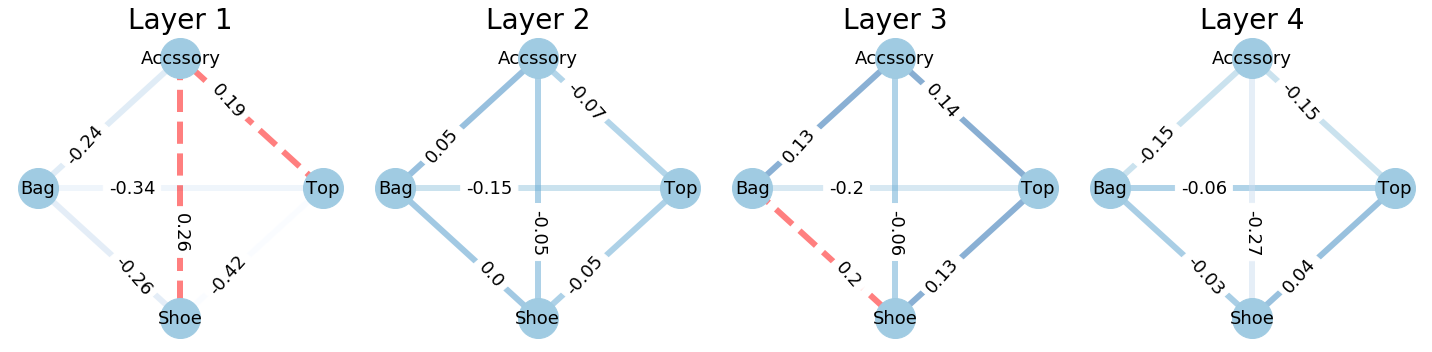

Predicted Score: 0.0000
Problem value of each item: tensor([-0.9295, -0.5032, -1.0435, -0.2117])
Order: [3, 1, 0, 2]



In [14]:
for idx in [i for i, e in enumerate(is_compat) if e==0]:
    print("="*88)
    print("ID: {}".format(labels[idx]))
    x = images[idx].to(device).unsqueeze(0)
    select = [i for i, l in enumerate(labels[idx]) if 'mean' not in l]

    # Step 1: show images in an outfit
    show_imgs(x[0], select)

    # Step 2: show diagnosis results
    relation, out = defect_detect(x, model)
    relation = relation.squeeze().cpu().data
    show_rela_diagnosis(relation, select, cmap=plt.cm.Blues)
    result, order = item_diagnosis(relation, select)
    print("Predicted Score: {:.4f}\nProblem value of each item: {}\nOrder: {}\n".format(out, result, order))

    # Step 3: substitute the problem items for revision
    # best_score, best_img_path = retrieve_sub(x, select, order)
    print("="*88)